# Spectroscopic Analysis

In this notebook, we'll walk through the basics of spectroscopy using Python. By the end, you should know how to go from a FITS file with a dispersed 2D spectrum to a 1D line spectrum with relative flux plotted versus wavelegth.

**Please make sure you have already done the bias subtraction and flat-fielding of your raw images before starting this notebook!**

In [1]:
# Import the modules we'll need in this notebook
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit

%matplotlib inline

In [2]:
datadir = "Sampledata/spectroscopy/"
sciencedir = datadir + 'science/'
calibrationdir = datadir + 'calibration/'
arcfile = calibrationdir + 'arc/ccds150513.0015.fits'
spectrumfile = sciencedir + 'ccds150511.0018.fits'

spectrum = fits.getdata(spectrumfile)
arc = fits.getdata(arcfile)

GRATILT                        / Grating Tilt (device units)                     [astropy.io.fits.card]
SLIT                           / Slit Width (device units)                       [astropy.io.fits.card]
SLITWIDTH=                 -97 /                                                 [astropy.io.fits.card]


Let's first plot the spectrum, to see what it looks like

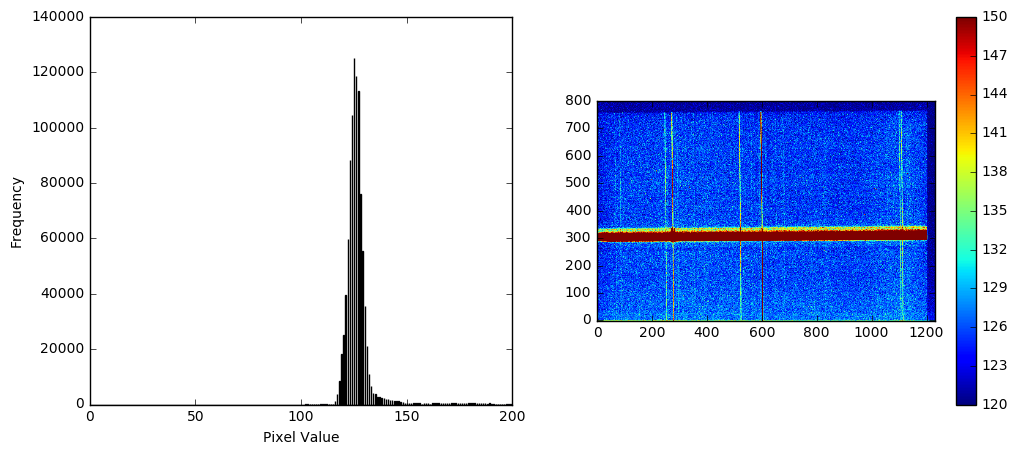

In [3]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
hist = ax1.hist(spectrum.flatten(), bins=1000, range=(0,200))
ax1.set_xlabel("Pixel Value")
ax1.set_ylabel("Frequency")
img = plt.imshow(spectrum, vmax=150, vmin=120, origin='lower')#, cmap=plt.get_cmap('gray'))
plt.colorbar()

## Spectroscopy-specific corrections

<!---Our spectrum is clearly visible around the y=300pix row. However, it appears to have quite a bit of noise...you can see bright lines that span the entire image, not just where our spectrum is -- these are sky lines! They are noise, so we need to subtract them out. We'll do that by subtracting the median value for each column from the value for each pixel in that column.--->

The first thing we'll need to check is that our spectrum is exactly aligned along the dispersion (x) direction and that it is confined to a constant y range on the image. We want to ensure that each x value corresponds to one specific wavelength and that there is no slanting or curvature in the spectrum. To do this:

1. Load the image into [DS9](http://ds9.si.edu/site/Download.html) and adjust the color scaling so you can see your spectrum. 
2. Place your cursor at one end of the spectrum, at the top of the brightest area of the spectrum. Note the (X,Y) position
3. Move your cursor along the top of the spectrum and note ~10 (X,Y) data points along the way
4. If there is a difference *anywhere*\* of 10+ pixels, you should perform the correction detailed in the next few cells

    \* This includes from start to end (indicative of a slanting spectrum) or from one end to the middle (indicative of a curved spectrum)
    
Let's first plot a scatter plot of our (X,Y) data to see what it looks like.

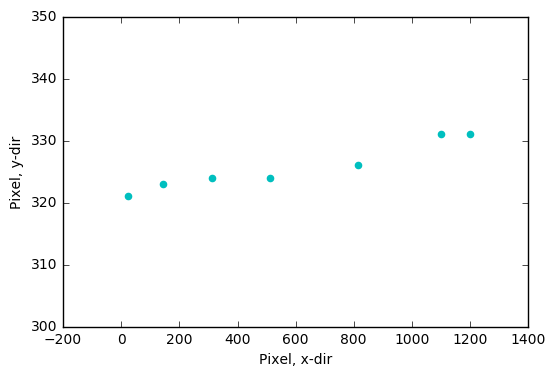

In [4]:
curvecorrect_top = [(1199,331),(1101,331),(816,326),(512,324),(311,324),(142,323),(22.5,321)]
x_top, y_top = zip(*curvecorrect_top)

plt.scatter(x_top, y_top, color='c')
plt.ylim(300,350)
plt.xlabel("Pixel, x-dir")
plt.ylabel("Pixel, y-dir")

Okay, there's a slight slant. Not too bad, but we should still correct it. The approach will be

1. Fit a curve to the data. Whether you fit a linear curve or some higher order polynomial will depend on how the data looks to you. We will be fitting a linear line for this exercise.
2. Choose a value to be the fixed width of your spectrum slice. We won't need the entire vertical width of the spectrum in order to extract our science. 10 pixels is usually sufficient.
3. For each X value, use your fitted curve to calculate the corresponding Y value. This will give you the Y value of the top of the spectrum. I recommend subtracting 5 pixels from this value in order to ensure you are fully inside the spectrum light.
4. Copy the values of the pixels between (Y-5) and (Y-15) into a new array. You should end up with a [len(X-dim)$ \times 10$] array.
5. Repeat #4 for a region away from the spectrum to create a background array. You could do this by adding 50 pixels to the Y values instead of subtracting 5 pixels.

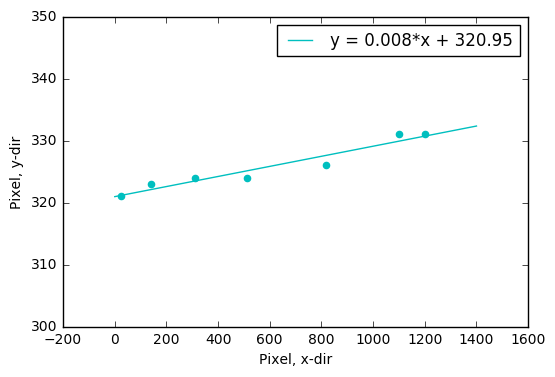

In [5]:
# Fit a line to our (X,Y) data
def linear_fit(x, *params):
    m, b = params
    return m*x + b

init = [1.0, 300.]
coeff, covar = curve_fit(linear_fit, x_top, y_top, p0=init)
x_fit = np.linspace(0,1400,1000)
y_fit = linear_fit(x_fit, *coeff)
label_str = "y = %.3f*x + %.2f" % (coeff[0], coeff[1])

plt.scatter(x_top, y_top, color='c')
plt.plot(x_fit, y_fit, color='c', label=label_str)
plt.ylim(300,350)
plt.xlabel("Pixel, x-dir")
plt.ylabel("Pixel, y-dir")
plt.legend()

In [6]:
x_pix = np.asarray([i for i in range(1200)]) 
y_pix = np.floor(linear_fit(x_pix, coeff[0], coeff[1])).astype(int)  # to ensure our pixel number is an int

# Arrays of length len(x_pix)
target_upper = y_pix - 5
target_lower = y_pix - 15
sky_upper = y_pix + 50
sky_lower = y_pix + 40

# Extract slices corresponding to the target spectrum and sky background
target = np.asarray(
            [spectrum.T[i, target_lower[i]:target_upper[i]] 
             for i in range(1200)]
           ).T

sky = np.asarray(
         [spectrum.T[i, sky_lower[i]:sky_upper[i]] 
          for i in range(1200)]
        ).T

In [7]:
# Subtract sky background from target
column_medians = np.median(sky, axis=0)
target_skysub = target - column_medians

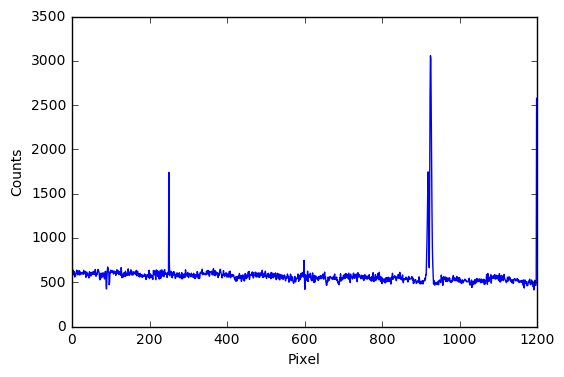

In [8]:
target_skysub_1d = np.sum(target_skysub, axis=0)
target_skysub_1d = target_skysub_1d[::-1]  # plot the spectrum correctly, i.e. blue to the left
plt.plot(x_pix, target_skysub_1d)
plt.xlabel("Pixel")
plt.ylabel("Counts")

## From Pixels to Wavelengths

The calibration arc file allows us to convert from image pixels to wavelengths. A noble gas lamp with well-known spectral lines is used to perform this calibration. Our calibration arc file made use of an argon and mercury lamp.

[   0   44   80  158  266  319  346  380  405  429  517  557  642  702  726
  742  855  886  968 1066 1114]


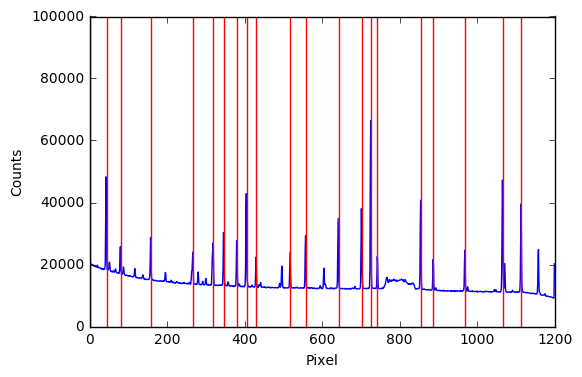

In [9]:
# Get a section of the arc image
# Don't need to use whole thing!
# Choose a region that seems relatively clean
arc_slice = arc[300:350, :1200]
arc_slice_1d = np.sum(arc_slice, axis=0)
arc_slice_1d = arc_slice_1d[::-1]  # again, put bluer wavelengths toward the left

# Find the peaks by setting a threshold
peaks = np.where(arc_slice_1d > 21000)[0]

# Some peaks also have pixels to either side that exceed the threshold
# We will take just the rightmost pixel for now
# Not 100% accurate, but okay for now
unique_peaks = peaks[np.where((peaks[1:] - peaks[:-1]) > 1)]

print(unique_peaks)
plt.plot(x_pix, arc_slice_1d)
for j in unique_peaks:
    plt.axvline(j, color='r')
plt.xlabel("Pixel")
plt.ylabel("Counts")

Compare to NIST data ![portrait=no](files/ccds_calibration_lamps_pngs/ar_blue3.png)

Hmm, that cluster around 550nm or so looks a lot like the cluster around pixels 300-400 in our calibration image...

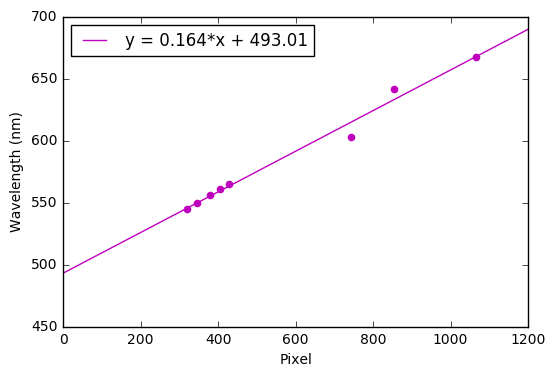

In [10]:
arc_pixels = [319, 346, 380, 405, 429, 742, 855, 1066]
arc_wavelengths = [545.1, 549.5, 555.8, 560.6, 565.0, 603.2, 641.6, 667.7]

# Fit a linear line to create a mapping between pixels and wavelengths
arc_init = [3, 500.0]
arc_coeff, arc_covar = curve_fit(linear_fit, arc_pixels, arc_wavelengths, p0=arc_init)
pix_fit = np.linspace(0,1200,1000)
wavelength_fit = linear_fit(pix_fit, *arc_coeff)
label_str = "y = %.3f*x + %.2f" % (arc_coeff[0], arc_coeff[1])

plt.scatter(arc_pixels, arc_wavelengths, color='m')
plt.plot(pix_fit, wavelength_fit, color='m', label=label_str)
plt.xlim(0,1200)
plt.xlabel("Pixel")
plt.ylabel("Wavelength (nm)")
plt.legend(loc=2)

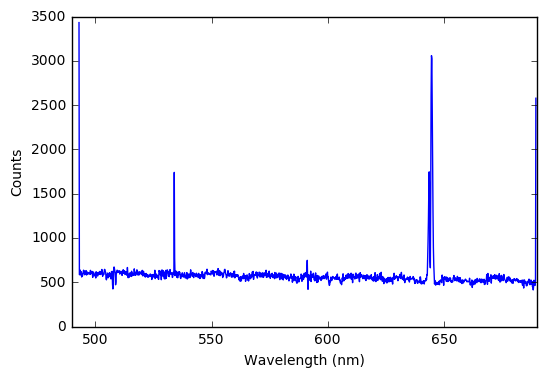

In [11]:
x_wavelengths = linear_fit(x_pix, *arc_coeff)

plt.plot(x_wavelengths, target_skysub_1d)
plt.xlim(490,690)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Counts")

## Analysis of the Spectrum

Let's try to fit a Gaussian to the large peak to the right (Actually, it's two peaks!)

In [12]:
# Let's define some potentially useful fitting functions

def gaussian_fit(x, *params):
    A, mu, sigma = params
    return A*np.exp(-(x-mu)**2 / (2.*sigma**2))

def gaussian_plus_linear_fit(x, *params):
    A, mu, sigma, m, b = params
    gaussian = A*np.exp(-(x-mu)**2 / (2.*sigma**2))
    linear = m*x + b
    return gaussian + linear

def doublegauss_plus_linear_fit(x, *params):
    A1, A2, mu1, dmu, sigma1, sigma2, m, b = params
    mu2 = mu1 + dmu
    
    gauss1 = A1*np.exp(-(x-mu1)**2 / (2.*sigma1**2))
    gauss2 = A2*np.exp(-(x-mu2)**2 / (2.*sigma2**2))
    linear = m*x + b
    
    return gauss1 + gauss2 + linear


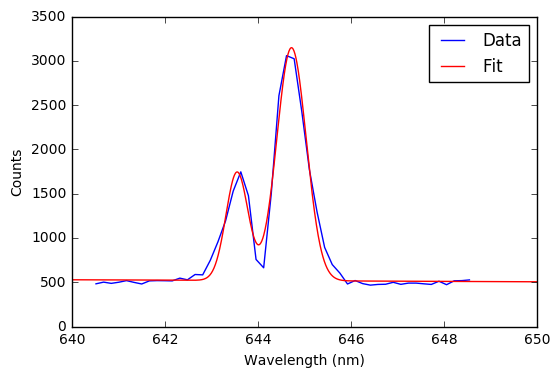

In [13]:
# 900-950 was obtained from the spectrum when it was still in pixel units
x_slice = x_wavelengths[900:950]
target_slice = target_skysub_1d[900:950]

init_doubgauss = [5,5,645,1,0.25,0.25,0,500]
coeff_gauss, covar_gauss = curve_fit(doublegauss_plus_linear_fit, x_slice, target_slice, p0=init_doubgauss)

x_fit_gauss = np.linspace(640,650, 1000)
y_fit_gauss = doublegauss_plus_linear_fit(x_fit_gauss, *coeff_gauss)

plt.plot(x_slice, target_slice, label="Data")
plt.plot(x_fit_gauss, y_fit_gauss, color='r', label="Fit")
plt.legend()
plt.xlabel("Wavelength (nm)")
plt.ylabel("Counts")

Not a perfect fit, but it's reasonable given the poor sampling of the data -- It reasonably accurately fits the shape and height of the peaks.

In [14]:
# Printing results
fit_params = ["A1","A2","mu","dmu","sigma1","sigma2","m","b"]
fwhm1 = 2.53*coeff_gauss[4]
fwhm2 = 2.53*coeff_gauss[5]
peak1 = doublegauss_plus_linear_fit(coeff_gauss[2], *coeff_gauss)
peak2 = doublegauss_plus_linear_fit(coeff_gauss[2]+coeff_gauss[3], *coeff_gauss)
StoN1 = peak1 / 500.  # 500 is currently continuum, need more general method
StoN2 = peak2 / 500.

print('-'*25)
print("| %-10s | %-8s |" % ("Parameter","Value"))
print("-"*25)
for p,v in zip(fit_params, coeff_gauss):
    print("| %-10s | %-8.2f |" % (p,v))

print("-"*25)
print("| %-10s | %-8.2f |" % ("FWHM1", fwhm1))
print("| %-10s | %-8.2f |" % ("Peak1", peak1))
print("| %-10s | %-8.2f |" % ("StoN1", StoN1))
print("- "*13)
print("| %-10s | %-8.2f |" % ("FWHM2", fwhm2))
print("| %-10s | %-8.2f |" % ("Peak2", peak2))
print("| %-10s | %-8.2f |" % ("StoN2", StoN2))
print("-"*25)

-------------------------
| Parameter  | Value    |
-------------------------
| A1         | 2630.98  |
| A2         | 1222.50  |
| mu         | 644.72   |
| dmu        | -1.17    |
| sigma1     | -0.32    |
| sigma2     | 0.24     |
| m          | -2.27    |
| b          | 1979.51  |
-------------------------
| FWHM1      | -0.80    |
| Peak1      | 3147.80  |
| StoN1      | 6.30     |
- - - - - - - - - - - - - 
| FWHM2      | 0.60     |
| Peak2      | 1744.85  |
| StoN2      | 3.49     |
-------------------------
